<a href="https://colab.research.google.com/github/sebastianrpo/SPIII_MiniP1/blob/main/MP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-proyecto 1: Análisis Multivariado de Señales Sismográficas**
##### Tratamiento de Señales III
##### Facultad de Ingeniería
##### Universidad de Antioquia
##### Daniela Acevedo Zuluaga - Sebastian Restrepo Valencia
##### 2023-1

## Carga de archivos e importación de librerías

Se carga la base de datos ***SismographyDB*** la cual contiene 21 señales de sismo de cada uno de los 3 tipos(Local, Regional y Telesismo). Estas se encuentran en el repositorio donde se encuentra este Notebook.

In [1]:
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisLoc.mat?raw=true" -O "sisLoc.mat"
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisReg.mat?raw=true" -O "sisReg.mat"
!wget "https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisTele.mat?raw=true" -O "sisTele.mat"

--2023-03-26 04:32:16--  https://github.com/sebastianrpo/SPIII_MiniP1/blob/main/sisLoc.mat?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/sebastianrpo/SPIII_MiniP1/raw/main/sisLoc.mat [following]
--2023-03-26 04:32:16--  https://github.com/sebastianrpo/SPIII_MiniP1/raw/main/sisLoc.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sebastianrpo/SPIII_MiniP1/main/sisLoc.mat [following]
--2023-03-26 04:32:17--  https://raw.githubusercontent.com/sebastianrpo/SPIII_MiniP1/main/sisLoc.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting resp

In [2]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd       
import seaborn as sns              
import scipy.io as sc
from pyts.decomposition import SingularSpectrumAnalysis
from scipy.signal import stft, bode, butter, lfilter, freqz
from scipy.stats import entropy

Se inicia cargando los datos de los archivos otorgados para la realización del mini-proyecto y posteriormente se grafican las 21 señales sísmicas para cada tipo (Local, Regional, Telesismo). Con el identificador se puede observar cada una de las señales individualmente.

(Text(0.5, 0, 'sample'), Text(0, 0.5, '$\\mu$ V'))

<Figure size 432x288 with 0 Axes>

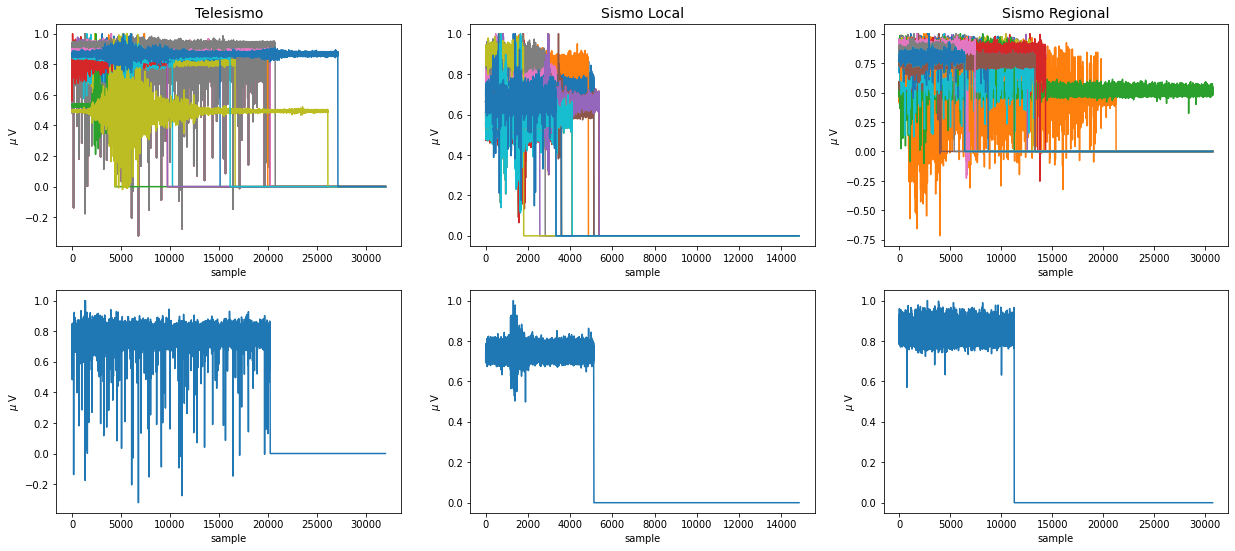

In [4]:
data = sc.loadmat('sisTele.mat')
data.keys() # variables del diccionario
TeleSignal = data['Y']
fs = data['fs']
plt.figure()
plt.figure(figsize=(21,9))
plt.subplot(2, 3, 1)
plt.plot(TeleSignal.T)
plt.title("Telesismo", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('sisLoc.mat')
data.keys() # variables del diccionario
LocSignal = data['Y']
plt.subplot(2, 3, 2)
plt.plot(LocSignal.T)
plt.title("Sismo Local", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

data = sc.loadmat('sisReg.mat')
data.keys() # variables del diccionario
RegSignal = data['Y']
plt.subplot(2, 3, 3)
plt.plot(RegSignal.T)
plt.title("Sismo Regional", fontsize=14), plt.xlabel('sample'), plt.ylabel('$\mu$ V')

idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.subplot(2, 3, 4)
plt.plot(TeleSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 5)
plt.plot(LocSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

plt.subplot(2, 3, 6)
plt.plot(RegSignal[idSignal,:])
plt.xlabel('sample'), plt.ylabel('$\mu$ V')

## Filtrado de la señal

Se utilizará un filtro Butterworth de orden 6 porque proporciona una respuesta en frecuencia plana en la banda de paso y una caída rápida en la banda de rechazo. Además, es fácil de implementar y ajustar la frecuencia de corte.

In [5]:
#Funciones para la implementación del filtro pasabandas.
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

<Figure size 432x288 with 0 Axes>

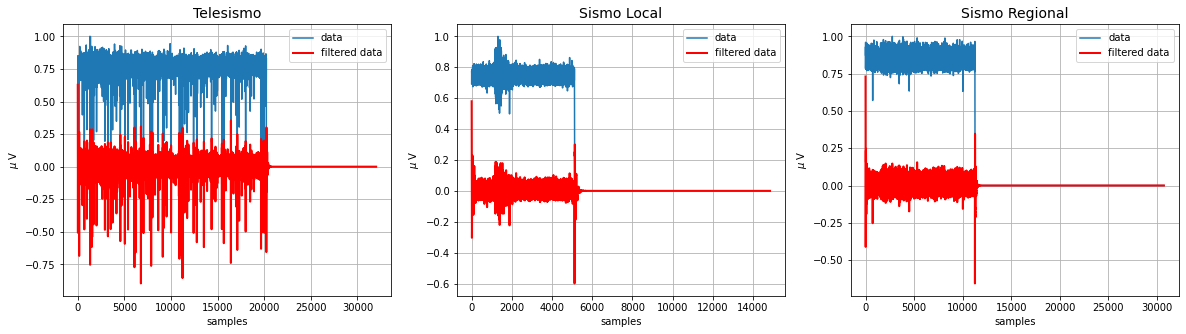

In [6]:
#Requisitos del filtro.
order = 6 #Orden del filtro.
fs = 101.0 #Frecuencia de muestreo, Hz.
cutoff1 = 50 #Highcut, Hz.
cutoff2 = 1 #Lowcut, Hz.

#Generamos matrices para almacenar las señales filtradas.
TeleSignalFiltered = np.zeros( (21, 32000) )
LocSignalFiltered = np.zeros( (21, 14848) )
RegSignalFiltered = np.zeros( (21, 30720) )

#Filtramos las señales.
for i in range(0, 21):
  TeleSignalFiltered[i,:] = butter_bandpass_filter(TeleSignal[i,:], cutoff2, cutoff1, fs, order)
  LocSignalFiltered[i,:] = butter_bandpass_filter(LocSignal[i,:], cutoff2, cutoff1, fs, order)
  RegSignalFiltered[i,:] = butter_bandpass_filter(RegSignal[i,:], cutoff2, cutoff1, fs, order)

#Graficamos la señal original y la señal filtrada.
idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1), plt.plot(TeleSignal[idSignal,:], label='data');
plt.subplot(1, 3, 1), plt.plot(TeleSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Telesismo", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2), plt.plot(LocSignal[idSignal,:], label='data');
plt.subplot(1, 3, 2), plt.plot(LocSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Sismo Local", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3), plt.plot(RegSignal[idSignal,:], label='data');
plt.subplot(1, 3, 3), plt.plot(RegSignalFiltered[idSignal,:], 'r-', linewidth=2, label='filtered data');
plt.title("Sismo Regional", fontsize=14), plt.xlabel('samples'), plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

Se puede observar que se filtran algunas señales de alta frecuencia, y también el filtro por si solo elimina el nivel DC de la señal.

<Figure size 432x288 with 0 Axes>

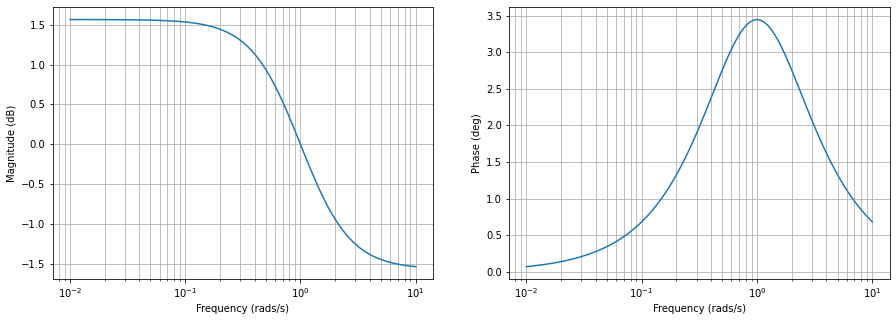

In [7]:
b, a = butter_bandpass(cutoff2, cutoff1, fs, order)
sys = (b, a)
w, mag, phase = bode(sys)

plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.semilogx(w, mag) #Bode magnitude plot, bandpass.
plt.xlabel('Frequency (rads/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.semilogx(w, phase) #Bode phase plot, bandpass.
plt.xlabel('Frequency (rads/s)') 
plt.ylabel('Phase (deg)')
plt.grid(True, which="both")

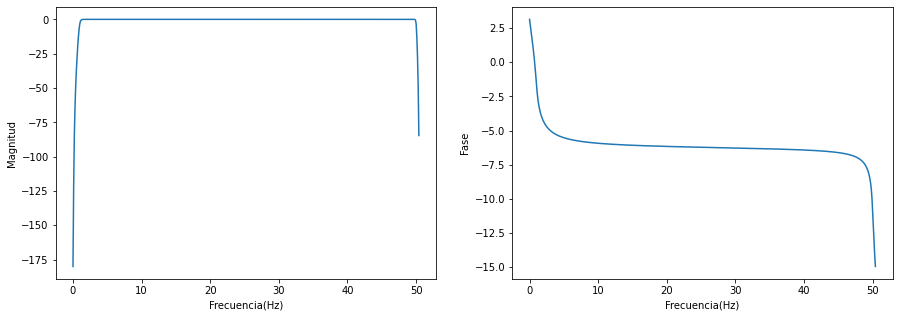

In [8]:
w, h = freqz(b,a)
plt.figure(figsize=[15,5])
plt.subplot(1, 2, 1)
plt.plot(fs*w/(2*np.pi),20*np.log10(abs(h)))
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Magnitud")
plt.subplot(1, 2, 2)
plt.plot(fs*w/(2*np.pi),np.unwrap(np.angle(h)))
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Fase")
plt.show()

Se puede ver que el filtro funciona bien, por lo que se confirma que el filtro utilizado puede ser usado y todo irá correctamente.

## Generación de señales subyacentes

Para el análisis se utilizarán 3 señales diferentes, aunque esta variable puede ser modificada. Para grupos de 4 o más señales, la graficación tarda un tiempo considerable, por lo que la modificación de este valor es un factor a tener en cuenta.

<Figure size 432x288 with 0 Axes>

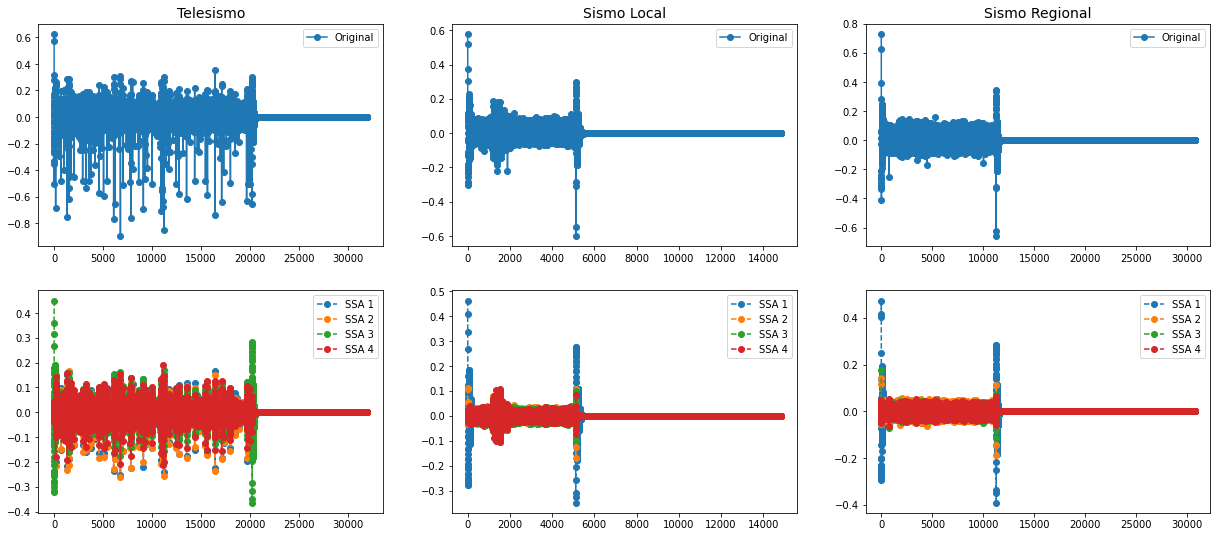

In [9]:
groups = 4 #Conjunto de señales subyacentes. Se puede cambiar el valor de esta variable para visualizar los efectos de utilizar mas o menos SSA's.
ssa = SingularSpectrumAnalysis(window_size=groups) #Singular Spectrum Analysis.

#Creamos las matrices con las nuevas señales subyacentes para cada conjunto de señales.
Tele_ssa = ssa.fit_transform(TeleSignalFiltered) 
Loc_ssa = ssa.fit_transform(LocSignalFiltered) 
Reg_ssa = ssa.fit_transform(RegSignalFiltered)

#Graficamos la señal origilan y las subseñales generadas.
idSignal = 0 #Identificador de la señal seleccionada (de las 21).
plt.figure()
plt.figure(figsize=(21,9))
plt.subplot(2, 3, 1), plt.plot(TeleSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Telesismo", fontsize=14), plt.legend(loc='best')
plt.subplot(2, 3, 2), plt.plot(LocSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Sismo Local", fontsize=14), plt.legend(loc='best')
plt.subplot(2, 3, 3), plt.plot(RegSignalFiltered[idSignal], 'o-', label='Original'), plt.title("Sismo Regional", fontsize=14), plt.legend(loc='best')

for i in range(groups):
    plt.subplot(2, 3, 4), plt.plot(Tele_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')
    plt.subplot(2, 3, 5), plt.plot(Loc_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')
    plt.subplot(2, 3, 6), plt.plot(Reg_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1)), plt.legend(loc='best')

La descomposición de la señal en señales subyacentes permite mejorar su comprensión y hacer una predicción más precisa de las tendencias futuras.
Se puede observar que al generarse las nuevas señales subyacentes se eliminan algunas componentes, lo que implica que más adelante cuando se hagan las gráficas para el análisis, las nuevas señales subyacentes tendrán unos valores diferentes que podrán dar otra visión

## Espectros
Se procede a calcular la STFT para las señales y también se grafica el espectro de cada una de las señales subyacentes. Para observar el comportamiento de cada una de ellas se modifica el identificador de la señal(idSignal) que va de 0 a 20, por lo que se puede ver cada una de las 21 señales.

<Figure size 432x288 with 0 Axes>

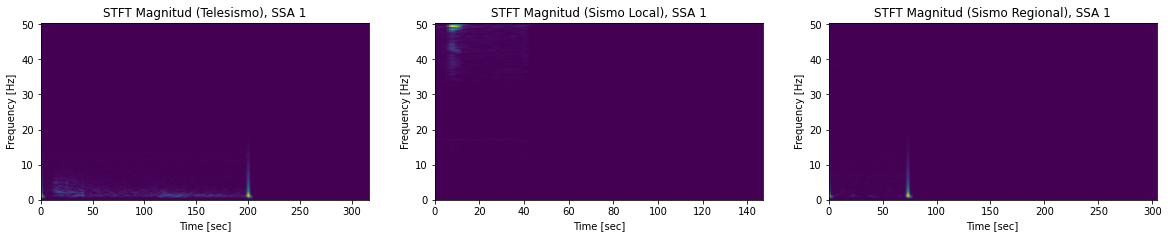

<Figure size 432x288 with 0 Axes>

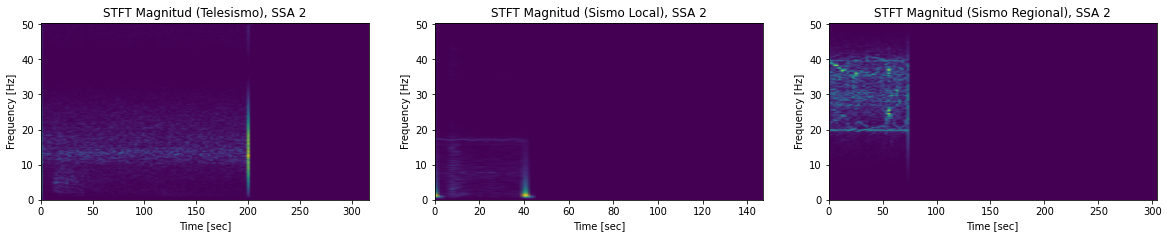

<Figure size 432x288 with 0 Axes>

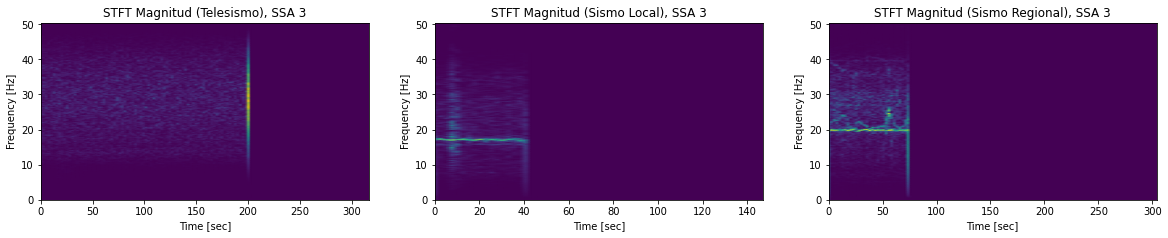

<Figure size 432x288 with 0 Axes>

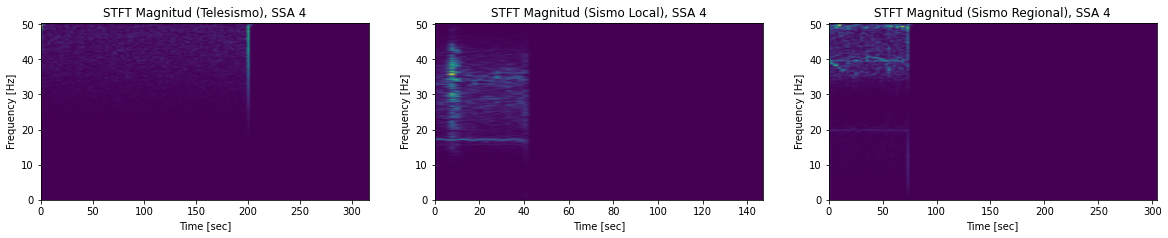

In [10]:
aux=[0]*groups
for i in range(0, groups):
  aux[i]=i*3

idSignal = 16 #Identificador de la señal seleccionada (de las 21).

#Calculemos la STFT
from scipy import signal
for i in range(0, groups):
  Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[idSignal,i], fs, nperseg=512)
  Tele_absZxx = np.abs(Tele_Zxx)
  Loc_f, Loc_t, Loc_Zxx = signal.stft(Loc_ssa[idSignal,i], fs, nperseg=512)
  Loc_absZxx = np.abs(Loc_Zxx)
  Reg_f, Reg_t, Reg_Zxx = signal.stft(Reg_ssa[idSignal,i], fs, nperseg=512)
  Reg_absZxx = np.abs(Reg_Zxx)

#Graficamos los espectros de las señales subyacentes generadas para cada tipo de sismo (a partir del identificador de la señal seleccionada).
  plt.figure()
  plt.figure(figsize=(20,15))
  plt.subplot(groups, 3, 1+aux[i]), plt.pcolormesh(Tele_t, Tele_f, Tele_absZxx, shading='gouraud') 
  plt.title('STFT Magnitud (Telesismo), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
  plt.subplot(groups, 3, 2+aux[i]), plt.pcolormesh(Loc_t, Loc_f, Loc_absZxx, shading='gouraud')
  plt.title('STFT Magnitud (Sismo Local), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')
  plt.subplot(groups, 3, 3+aux[i]), plt.pcolormesh(Reg_t, Reg_f, Reg_absZxx, shading='gouraud')
  plt.title('STFT Magnitud (Sismo Regional), SSA {0}'.format(i + 1)), plt.ylabel('Frequency [Hz]'), plt.xlabel('Time [sec]')

* En los sismos locales se puede ver claramente que la duración es mucho menor en comparación a los Regionales y Telesismo. Por ejemplo, en el idSignal=16, mientras el sismo Local dura hasta los 40s, el Regional va hasta aproximadamente 80s y el Telesismo hasta los 200s
* A pesar de ser los más cortos, los Locales son los que mayor frecuencia muestran generalmente, mientras que los sismos Regionales muestran frecuencias repartidas entre los 0 y 50Hz y de igual forma pasa con los Telesismos
* Por lo general los sismos locales muestran las magnitudes más altas en frecuencias bajas, mientras que los Telesismos muestran frecuencias altas por todas las frecuencias. Esto se debe a que los Telesismos pueden ser registrados en distancias mucho más largas y amplias.

## Extracción de características

Se van a extraer las siguientes características: Energía, Potencia máxima, frecuencia en la potencia máxima, media, varianza, máximo y mínimo del espectro

In [11]:
#Funcion para el cálculo de la energía.
def signalEnergy(signalInput):  
  sum = 0
  for k in range(len(signalInput)):
    sum+=pow(signalInput[k],2)     
  sigEnergy = sum
  return sigEnergy 

In [12]:
#Funcion para la extracción de características.
def extract_features(Zxx, f, ssa):
  absZxx = np.abs(Zxx)
  maxP = np.max(absZxx)
  id = np.where(absZxx==maxP)
  frecPmax = np.squeeze(f[id[0]])
  energy=signalEnergy(ssa)
  maxF = np.max(absZxx,axis=1)
  meanP = np.mean(maxF)
  varP = np.var(maxF)
  maxSpectrum = np.max(maxF)
  minSpectrum = np.min(maxF)

  dataRow = np.random.rand(7) #Creamos un ndarray de tamaño 7, el cual almacenará las características.
  #Enviamos las características de manera organizada a las posiciones correspondientes del ndarray creado.
  dataRow[0]=maxP
  dataRow[1]=frecPmax
  dataRow[2]=energy
  dataRow[3]=meanP 
  dataRow[4]=varP 
  dataRow[5]=maxSpectrum 
  dataRow[6]=minSpectrum 
 
  return dataRow

In [13]:
Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[0,0], fs, nperseg=512)
dataRow = extract_features(Tele_Zxx, Tele_f, Tele_ssa[0,0])

print('Potencia máxima: ',dataRow[0])
print('Frecuencia en la potencia máxima: ',dataRow[1],' Hz')
print('Energia: ',dataRow[2])
print('Media: ',dataRow[3])
print('Varianza: ',dataRow[4])
print('Máximo del espectro: ',dataRow[5])
print('Mínimo del espectro: ',dataRow[6])


TeleMatrix = np.zeros( (21,7*groups) )
LocMatrix = np.zeros( (21,7*groups) )
RegMatrix = np.zeros( (21,7*groups) )

#Creamos un ciclo for que recorre las 21 señales.
for idSignal in range(0, 21):

#Creamos ndarrays que serán llenados con las características extraidas, fila a fila.
  dataRowTele = np.zeros( (0, 0) ) 
  dataRowLoc = np.zeros( (0, 0) )
  dataRowReg = np.zeros( (0, 0) )

#Creamos un ciclo for que recorre los i grupos.
  for i in range(0, groups):
    Tele_f, Tele_t, Tele_Zxx = signal.stft(Tele_ssa[idSignal,i], fs, nperseg=512) 
    featuresTele = extract_features(Tele_Zxx, Tele_f, Tele_ssa[idSignal,i]) #Extraemos características para el telesismo de la señal idSignal, subgrupo i.
    dataRowTele = np.append(dataRowTele, featuresTele) #Concatenamos las características de los subgrupos del telesismo idSignal, en una sola fila. 

    Loc_f, Loc_t, Loc_Zxx = signal.stft(Loc_ssa[idSignal,i], fs, nperseg=512)
    featuresLoc = extract_features(Loc_Zxx, Loc_f, Loc_ssa[idSignal,i]) #Extraemos características para el sismo local de la señal idSignal, subgrupo i.
    dataRowLoc = np.append(dataRowLoc, featuresLoc) #Concatenamos las características de los subgrupos del sismo local idSignal, en una sola fila. 

    Reg_f, Reg_t, Reg_Zxx = signal.stft(Reg_ssa[idSignal,i], fs, nperseg=512)
    featuresReg = extract_features(Reg_Zxx, Reg_f, Reg_ssa[idSignal,i]) #Extraemos características para el sismo regional de la señal idSignal, subgrupo i.
    dataRowReg = np.append(dataRowReg, featuresReg) #Concatenamos las características de los subgrupos del sismo regional idSignal, en una sola fila. 
  
  TeleMatrix[idSignal:]= dataRowTele #Construimos una matriz a partir de las filas con las características de los telesismos.
  LocMatrix[idSignal:] = dataRowLoc #Construimos una matriz a partir de las filas con las características de los sismos locales.
  RegMatrix[idSignal:] = dataRowReg #Construimos una matriz a partir de las filas con las características de los sismos regionales.

#Concatenamos las matrices de las características de los telesismos, sismos locales y sismos regionales en una sola matriz.
dataSet_X = np.concatenate((TeleMatrix,LocMatrix,RegMatrix),axis = 0)

Potencia máxima:  0.011546077695360106
Frecuencia en la potencia máxima:  22.8828125  Hz
Energia:  9.046814680197004
Media:  0.0021608785276285044
Varianza:  3.378366221715838e-06
Máximo del espectro:  0.011546077695360106
Mínimo del espectro:  0.0002415629207038004


## Numpy Array to DataFrame

In [14]:
#Imprimimos el ndarray que contiene las caracterízticas extraidas para cada señal.
print(dataSet_X)

[[1.15460777e-02 2.28828125e+01 9.04681468e+00 ... 6.84027349e-06
  1.16136902e-02 2.49291553e-05]
 [1.15460777e-02 2.28828125e+01 9.04681468e+00 ... 6.84027349e-06
  1.16136902e-02 2.49291553e-05]
 [1.15460777e-02 2.28828125e+01 9.04681468e+00 ... 6.84027349e-06
  1.16136902e-02 2.49291553e-05]
 ...
 [3.28893342e-02 1.38085938e+00 5.75328328e+00 ... 4.60317558e-07
  4.27235218e-03 1.37815228e-04]
 [3.28893342e-02 1.38085938e+00 5.75328328e+00 ... 4.60317558e-07
  4.27235218e-03 1.37815228e-04]
 [3.28893342e-02 1.38085938e+00 5.75328328e+00 ... 4.60317558e-07
  4.27235218e-03 1.37815228e-04]]


In [15]:
#Nombramos las etiquetas correspondientes a las columnas.
columnNames=[]
for i in range(0, groups):
  auxN=(['Pot(SSA{0})'.format(i + 1),'F_Pmax(SSA{0})'.format(i + 1),'Energia(SSA{0})'.format(i + 1),'Media(SSA{0})'.format(i + 1),'Var(SSA{0})'.format(i + 1),'Max(SSA{0})'.format(i + 1),'Min(SSA{0})'.format(i + 1)])
  columnNames=columnNames+auxN

df = pd.DataFrame(dataSet_X,columns=columnNames)

In [16]:
#Agregamos las etiquetas que nos permitirán identificar a que tipo de sismo corresponde cada señal.
mixTags = ["" for x in range(63)]
for i in range(0,21,1):
  mixTags[i] = ("Tele")
for j in range(21,42,1):
  mixTags[j] = ("Loc")
for l in range(42,63,1):
  mixTags[l] = ("Reg")

print(mixTags) 
df['Tipo'] = mixTags

['Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Tele', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Loc', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg', 'Reg']


In [17]:
df #Visualizamos el contenido de nuestro dataframe, organizado mediante una tabla con sus respectivas etiquetas para filas y columnas.

,Pot(SSA1),F_Pmax(SSA1),Energia(SSA1),Media(SSA1),Var(SSA1),Max(SSA1),Min(SSA1),Pot(SSA2),F_Pmax(SSA2),Energia(SSA2),...,Max(SSA3),Min(SSA3),Pot(SSA4),F_Pmax(SSA4),Energia(SSA4),Media(SSA4),Var(SSA4),Max(SSA4),Min(SSA4),Tipo
0,0.011546,22.882812,9.046815,0.002161,0.000003,0.011546,0.000242,0.008621,22.882812,8.301433,...,0.032258,0.000837,0.011614,43.990234,9.489283,0.001917,6.840273e-06,0.011614,0.000025,Tele
1,0.011546,22.882812,9.046815,0.002161,0.000003,0.011546,0.000242,0.008621,22.882812,8.301433,...,0.032258,0.000837,0.011614,43.990234,9.489283,0.001917,6.840273e-06,0.011614,0.000025,Tele
2,0.011546,22.882812,9.046815,0.002161,0.000003,0.011546,0.000242,0.008621,22.882812,8.301433,...,0.032258,0.000837,0.011614,43.990234,9.489283,0.001917,6.840273e-06,0.011614,0.000025,Tele
3,0.011546,22.882812,9.046815,0.002161,0.000003,0.011546,0.000242,0.008621,22.882812,8.301433,...,0.032258,0.000837,0.011614,43.990234,9.489283,0.001917,6.840273e-06,0.011614,0.000025,Tele
4,0.011546,22.882812,9.046815,0.002161,0.000003,0.011546,0.000242,0.008621,22.882812,8.301433,...,0.032258,0.000837,0.011614,43.990234,9.489283,0.001917,6.840273e-06,0.011614,0.000025,Tele
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.036013,1.380859,7.008241,0.003822,0.000033,0.036013,0.000603,0.003566,38.466797,0.651810,...,0.003645,0.000031,0.004997,49.908203,0.565115,0.000845,7.435365e-07,0.004997,0.000169,Reg
59,0.034351,1.380859,6.416762,0.003663,0.000030,0.034351,0.000633,0.006906,49.513672,0.847622,...,0.003945,0.000023,0.004716,17.162109,0.425404,0.001099,5.990585e-07,0.004716,0.000213,Reg
60,0.032889,1.380859,5.753283,0.003421,0.000027,0.032889,0.000535,0.011826,49.908203,1.473595,...,0.002268,0.000002,0.004272,16.767578,0.422022,0.000969,4.603176e-07,0.004272,0.000138,Reg
61,0.032889,1.380859,5.753283,0.003421,0.000027,0.032889,0.000535,0.011826,49.908203,1.473595,...,0.002268,0.000002,0.004272,16.767578,0.422022,0.000969,4.603176e-07,0.004272,0.000138,Reg


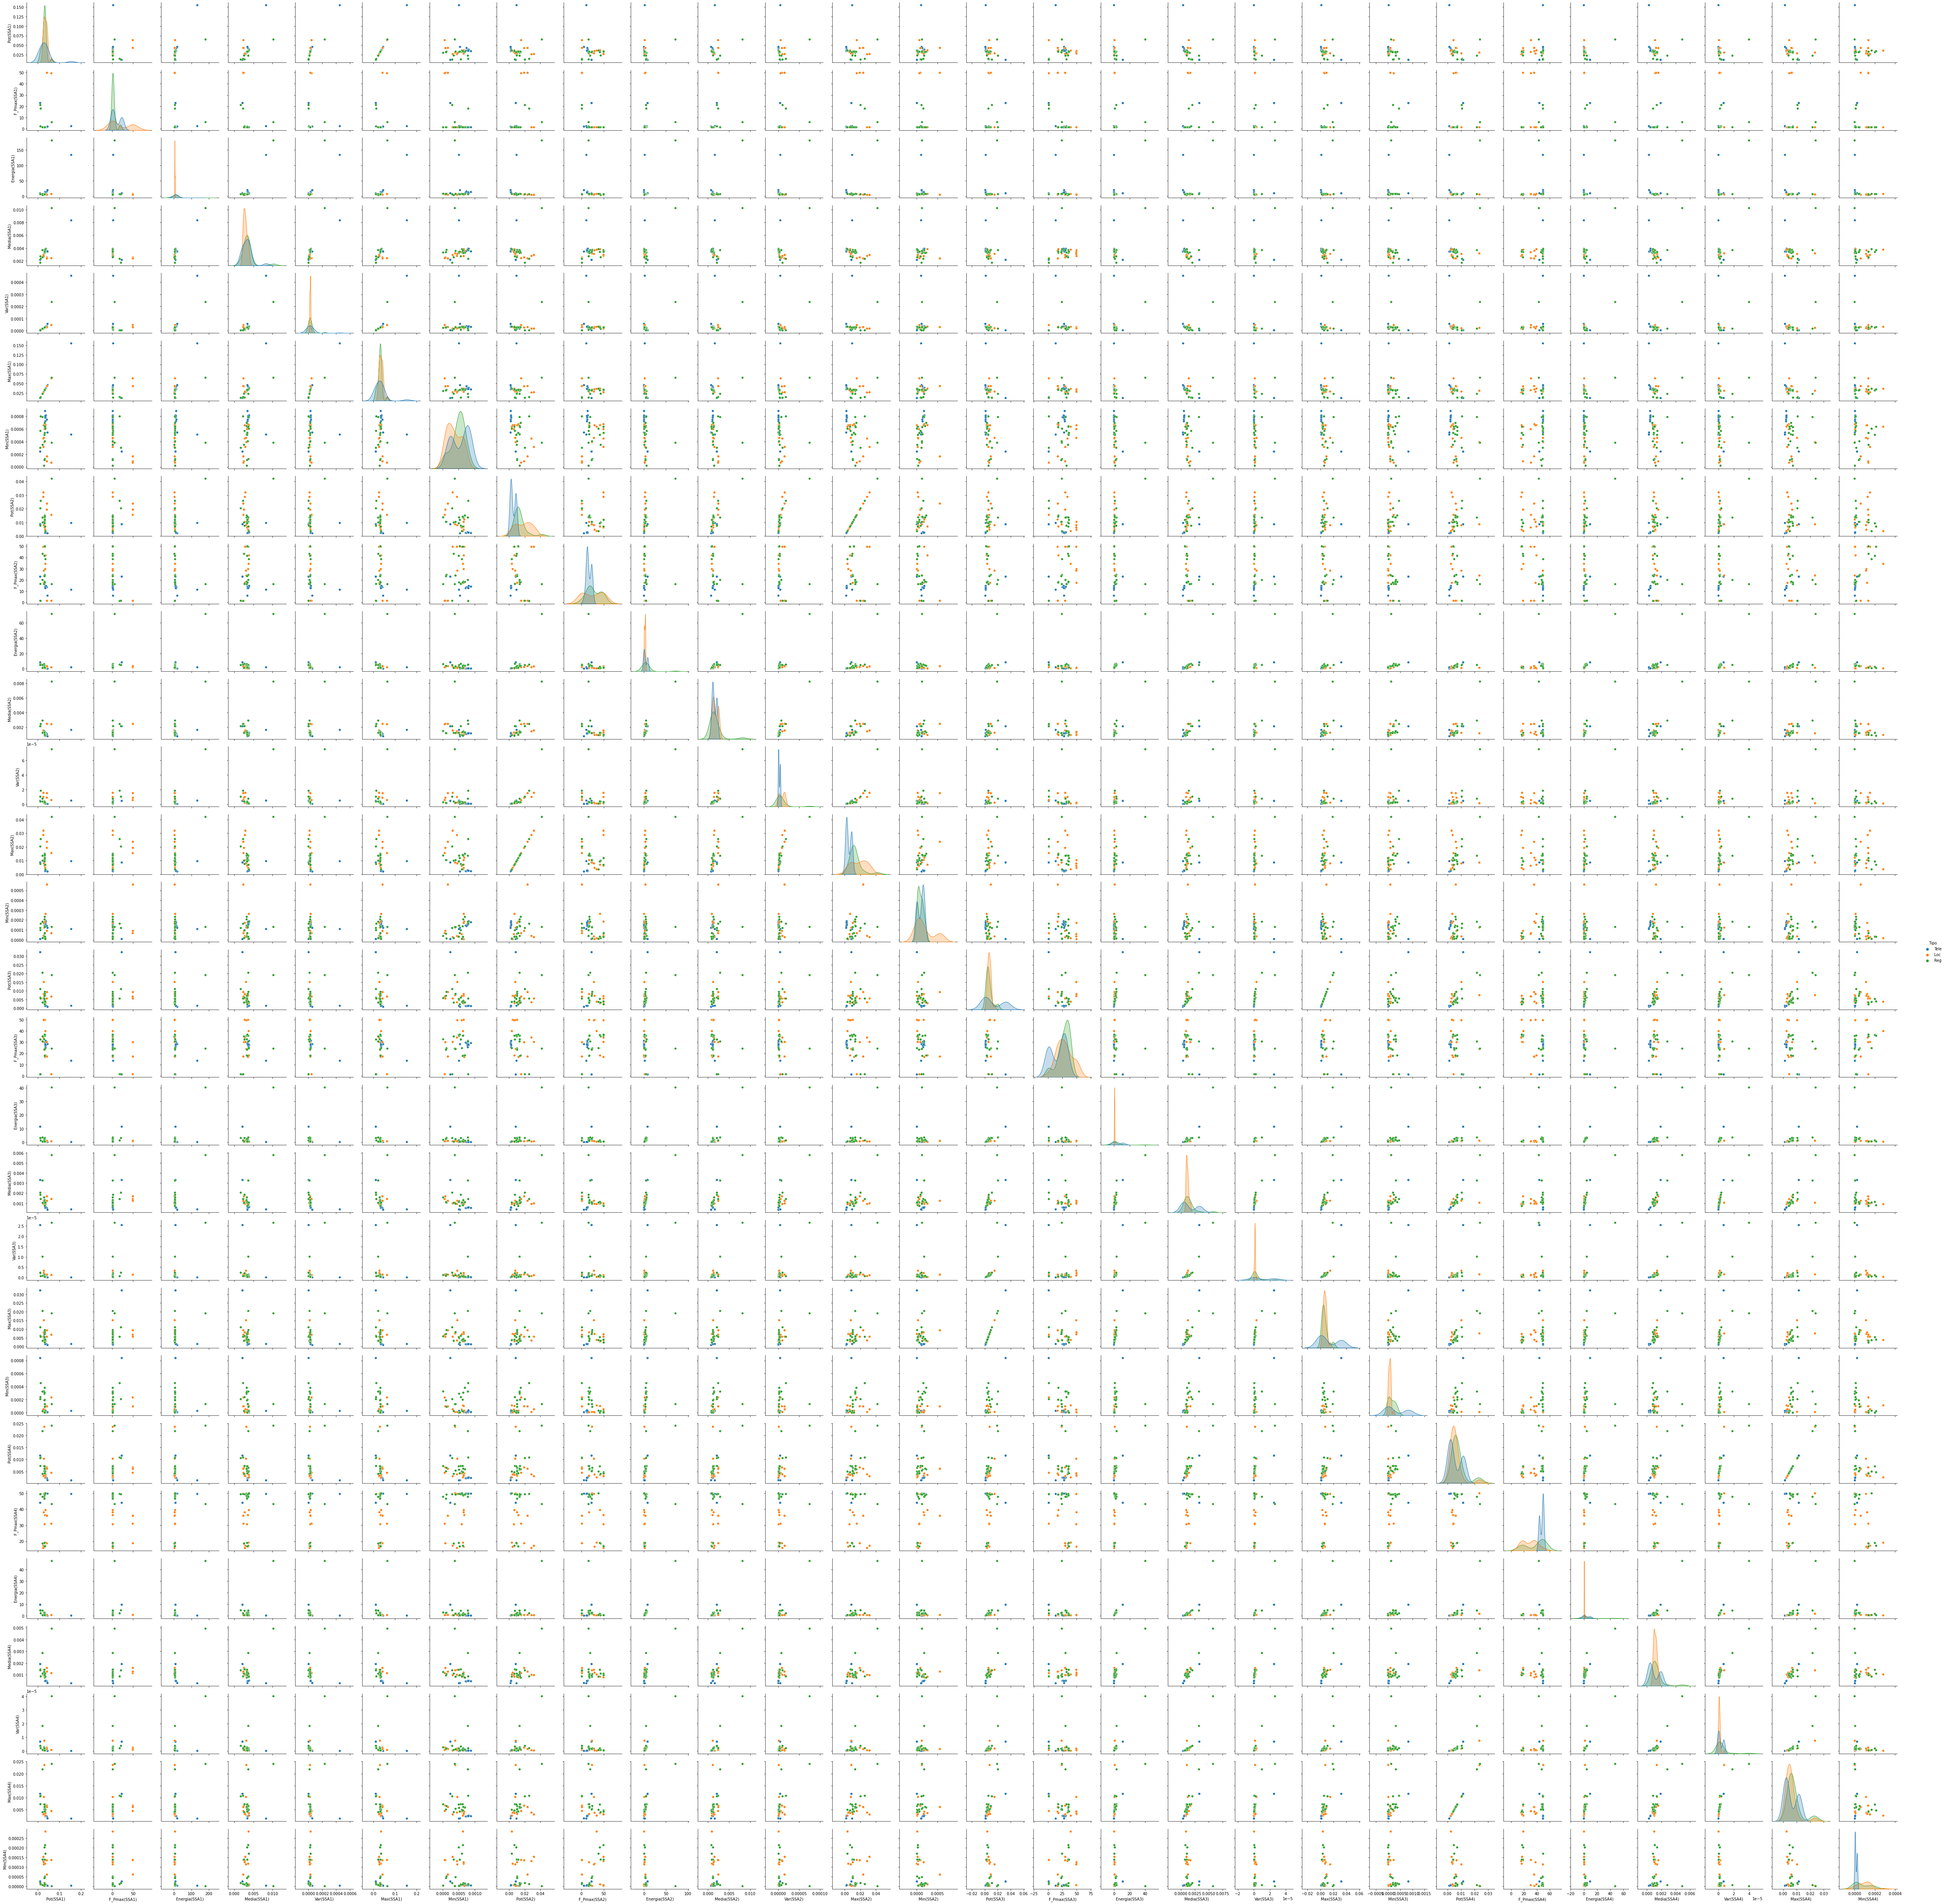

In [18]:
sns.pairplot(df, hue="Tipo")

## Análisis

* En los gráficos de frecuencia en la potencia máxima, se puede observar claramente que los telesismos y los sismos regionales, generalmente tienen una magnitud mucho mayor a los sismos locales.
* El comportamiento anterior también se puede observar en los datos de frecuencia en la potencia máxima con respecto al resto de variables ya que los datos locales siempre quedan separados de los datos de telesismo y regionales.
* Cuando se observan las gráficas de el mínimo del espectro vs las otras variables se ve que siempre los valores están tendiendo a cero. Es posible que el mínimo en el espectro se encuentre en la frecuencia más baja que ha sido eliminada por el filtro. En este caso, el hecho de que los datos en el mínimo del espectro estén en cero indica que el filtro ha sido efectivo para eliminar esas frecuencias. Aunque también puede ser perjudicial al observar que se puede estar perdiendo información.
* Los sismos locales muestran una energía muchísimo mayor que los sismos regionales y los telesismos.

##Conclusiones

* Se debe analizar muy bien cuántos grupos de representación se van a utilizar ya que una cantidad muy grande de éstos conlleva un costo computacional alto, y no necesariamente asegura un mejor análisis de las señales, por lo menos de una forma visual.
* Los temblores son señales muy débiles y a menudo están ocultos por el ruido de fondo. Aplicar un filtro ayuda a reducir el ruido y a aclarar la señal, lo que facilita su análisis y permite identificar mejor las características de éstos.
* Los temblores pueden tener diferentes frecuencias y la aplicación de filtros permite separar las diferentes componentes de frecuencia de la señal, lo que facilita su análisis y puede proporcionar información útil sobre las características del temblor.
